In [ ]:
%pip install -r ../requirements.txt

In [1]:
from schema import WLD

wld = WLD(file_path="../data/example-chappy.wld")

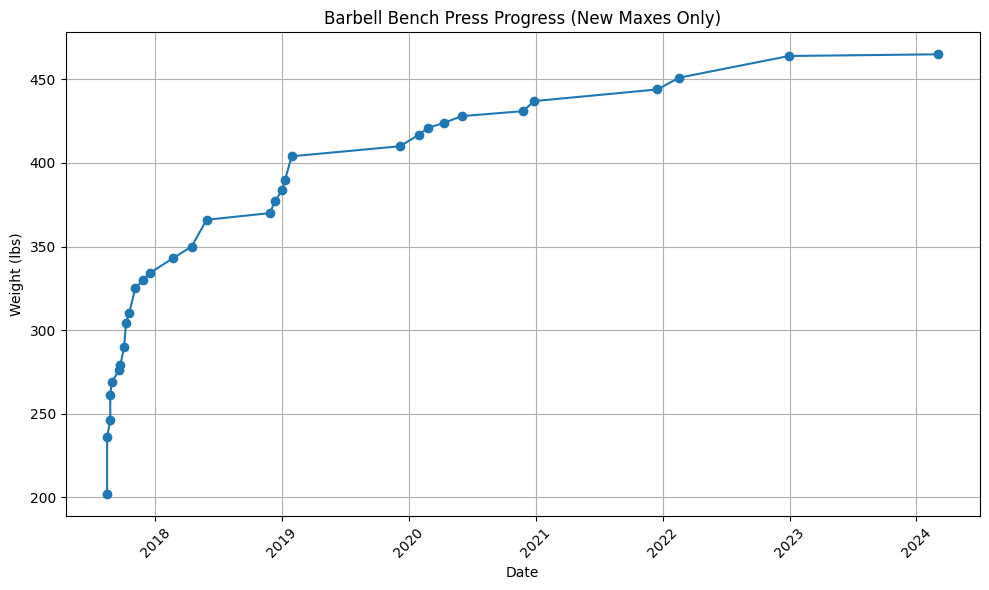

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect bench press data
bench_data = []
for workout in wld.workouts:
    for exercise in workout.exercises:
        if exercise.name == "Barbell Bench Press":
            for set_data in exercise.sets:
                if set_data.weight is not None:  # Only include sets with weight data
                    bench_data.append({"date": workout.date, "weight": set_data.oneRM})

# Convert to DataFrame and sort by date
df = pd.DataFrame(bench_data)
df = df.sort_values("date")

# Plot max weight over all time (showing only when a new max is achieved)
running_max = 0
max_data = []
for _, row in df.iterrows():
    if row["weight"] > running_max:
        running_max = row["weight"]
        max_data.append({"date": row["date"], "weight": row["weight"]})

max_df = pd.DataFrame(max_data)

plt.figure(figsize=(10, 6))
plt.plot(max_df["date"], max_df["weight"], marker="o")
plt.title("Barbell Bench Press Progress (New Maxes Only)")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()